In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, random

import numpyro
from numpyro.diagnostics import hpdi, print_summary, summary
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value, log_likelihood, NUTS, MCMC, Predictive
from numpyro.infer.autoguide import AutoLaplaceApproximation, AutoNormal

Qn1. Revisit the marriage, age, and happiness collider bias example from Chap-
ter 6. Run models m6.9 and m6.10 again (pages 178–179). Compare these
two models using both PSIS and WAIC. Which model is expected to make
better predictions, according to these criteria? On the basis of the causal
model, how should you interpret the parameter estimates from the model
preferred by PSIS and WAIC?


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
        age     33.00     18.77     33.00      1.00     58.00      2.51      2.64
  happiness      0.00      1.21      0.00     -2.00      1.58    338.78      1.00
    married      0.28      0.45      0.00      0.00      1.00     48.04      1.18



sample: 100%|██████████| 1000/1000 [00:00<00:00, 2429.91it/s, 3 steps of size 4.21e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.20      0.07     -0.20     -0.31     -0.09    735.60      1.00
      a[1]      1.23      0.09      1.23      1.09      1.38    554.49      1.01
        bA     -0.69      0.12     -0.68     -0.88     -0.50    621.02      1.01
     sigma      1.02      0.02      1.02      0.98      1.06   1646.54      1.00

Number of divergences: 0


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'bA'}>,
        <AxesSubplot:title={'center':'bA'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

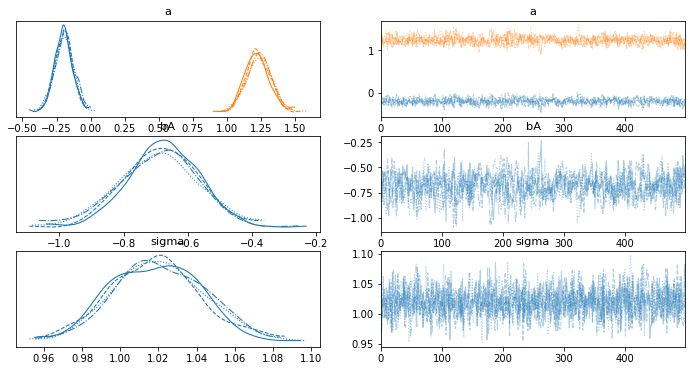

In [2]:
# 6.9 
def sim_happiness(seed=1977, N_years=1000, max_age=65, N_births=20, aom=18):
    # age existing individuals & newborns
    A = jnp.repeat(jnp.arange(1, N_years + 1), N_births)
    # sim happiness trait - never changes
    H = jnp.repeat(jnp.linspace(-2, 2, N_births)[None, :], N_years, 0).reshape(-1)
    # not yet married
    M = jnp.zeros(N_years * N_births, dtype=jnp.int32)

    def update_M(i, M):
        # for each person over 17, chance get married
        married = dist.Bernoulli(logits=(H - 4)).sample(random.PRNGKey(seed + i))
        return jnp.where((A >= i) & (M == 0), married, M)

    M = lax.fori_loop(aom, max_age + 1, update_M, M)
    # mortality
    deaths = A > max_age
    A = A[~deaths]
    H = H[~deaths]
    M = M[~deaths]

    d = pd.DataFrame({"age": A, "married": M, "happiness": H})
    return d

d = sim_happiness(seed=1977, N_years=1000)
print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)
d2 = d[d.age > 17].copy()  # only adults
d2["A"] = (d2.age - 18) / (65 - 18)
d2["mid"] = d2.married


def m6_9(mid, A, happiness):
    a = numpyro.sample("a", dist.Normal(0, 1).expand([len(set(mid))]))
    bA = numpyro.sample("bA", dist.Normal(0, 2))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a[mid] + bA * A
    numpyro.sample("happiness", dist.Normal(mu, sigma), obs=happiness)

def get_mcmc(model, data):
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
    dat = {k:v.to_numpy() for k,v in data.items()}
    mcmc.run( random.PRNGKey(0), **dat)
    mcmc.print_summary()
    return mcmc

mcmc6_9 = get_mcmc(m6_9, d2[['A', 'mid', 'happiness']])
samples_69 = az.from_numpyro(mcmc6_9)
az.plot_trace(samples_69)


sample: 100%|██████████| 1000/1000 [00:00<00:00, 2643.37it/s, 7 steps of size 3.70e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.07     -0.00     -0.12      0.13    818.19      1.01
        bA     -0.00      0.13      0.00     -0.20      0.22    826.88      1.01
     sigma      1.22      0.03      1.21      1.17      1.26   1388.00      1.00

Number of divergences: 0


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'bA'}>,
        <AxesSubplot:title={'center':'bA'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

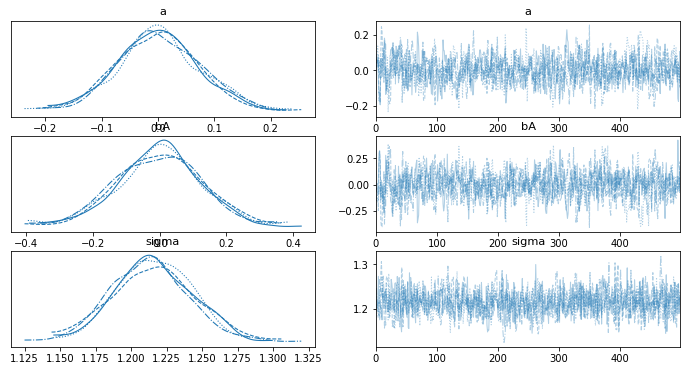

In [3]:
# 6.10
def m6_10(A, happiness):
    a = numpyro.sample("a", dist.Normal(0, 1))
    bA = numpyro.sample("bA", dist.Normal(0, 2))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bA * A
    numpyro.sample("happiness", dist.Normal(mu, sigma), obs=happiness)

mcmc6_10 = get_mcmc(m6_10, d2[['A', 'happiness']])
samples_610 = az.from_numpyro(mcmc6_10)
az.plot_trace(samples_610)

In [6]:
az.compare({'m6.9': samples_69, 'm6.10': samples_610}, ic="loo", scale='deviance')

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m6.9,0,2764.195455,3.690461,0.000000,0.990473,35.230343,0.000000,False,deviance
m6.10,1,3101.960210,2.368192,337.764755,0.009527,27.655671,33.313746,False,deviance


In [5]:
az.compare({"m6.9": samples_69, "m6.10": samples_610, }, ic="waic", scale="deviance")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6.9,0,2764.17681,3.681139,0.00000,0.990488,35.229675,0.000000,False,deviance
m6.10,1,3101.94699,2.361581,337.77018,0.009512,27.655311,33.313146,False,deviance


Qn2. Reconsider the urban fox analysis from last week’s homework. On the
basis of PSIS and WAIC scores, which combination of variables best predicts
body weight (W, weight)? How would you interpret the estimates from the
best scoring model?

Qn3. Build a predictive model of the relationship show on the cover of the book,
the relationship between the timing of cherry blossoms and March temper-
ature in the same year. The data are found in data(cherry_blossoms).
Consider at least two functions to predict doy with temp. Compare them
with PSIS or WAIC.
Suppose March temperatures reach 9 degrees by the year 2050. What does
your best model predict for the predictive distribution of the day-in-year that
the cherry trees will blossom?